# Exercise: Introduction to Pytorch
---

This week’s exercise will walk you through the basics of Pytorch. The goal is for you to be familiar with:
- What is a computational graph
- How to define a pytorch data loader
- How to build a neural network in pytorch
- How to define a pytorch optimizer
- How to train a neural network in pytorch


In addition to this exercise, we recommend you to have a look at the official tutorials on pytorch.org

https://pytorch.org/tutorials/index.html

Links:

- [Task2: Play with MNIST Fashion and Pytroch](#Task2)



Software verion:
- Python 3.6
- Pytorch 1.0


<a id='Task2'></a>
## Task2: Play with MNIST Fashion and Pytroch

---
Your task is to use Pytorch to build a model and train a neural network on the MNIST Fashion dataset. Before you can start you need to have access to the MNIST Fashion dataset. If you use an IFI computer, the defualt path given in this jupyter notebook will root you to the data. If you work on any other computer, you will need to download the MNIST Fashion dataset. You can download the files from: https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion

MINST Fashion files:
- t10k-images-idx3-ubyte.gz
- t10k-labels-idx1-ubyte.gz
- train-images-idx3-ubyte.gz
- train-labels-idx1-ubyte.gz

The MNIST Fashion dataset have 10 classes: ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'].  

The training set consists of 60,000 images and the test set consists of 10,000 images. The images are of size [28,28].


**Important!**
You will need to add code at locations indicated with "ToDo" only.



- <b>"%matplotlib inline"</b> is used to plot figures within the jupyter notebook


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.utility_functions import datasetFashionMNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

%matplotlib inline

---
### Step 1: Handling of the data

The following cell creates two instances of "datasetFashionMNIST". The "datasetFashionMNIST" is a "torch.utils.data.Dataset" written for the MNIST Fashion dataset.

If you do not use an IFI computer edit the "dataPath" to the location of the MNIST Fashion dataset.


In [14]:
#Path to the MNIST Fashion files
dataPath = 'data/MNIST_fashion/'

# Create dataset objects
train_dataset = datasetFashionMNIST(dataPath=dataPath, train=True)
val_dataset   = datasetFashionMNIST(dataPath=dataPath, train=False)


In [22]:
(train_dataset.labels[:10] == 5)

array([False, False, False, False, False, False, False, False,  True,
        True])

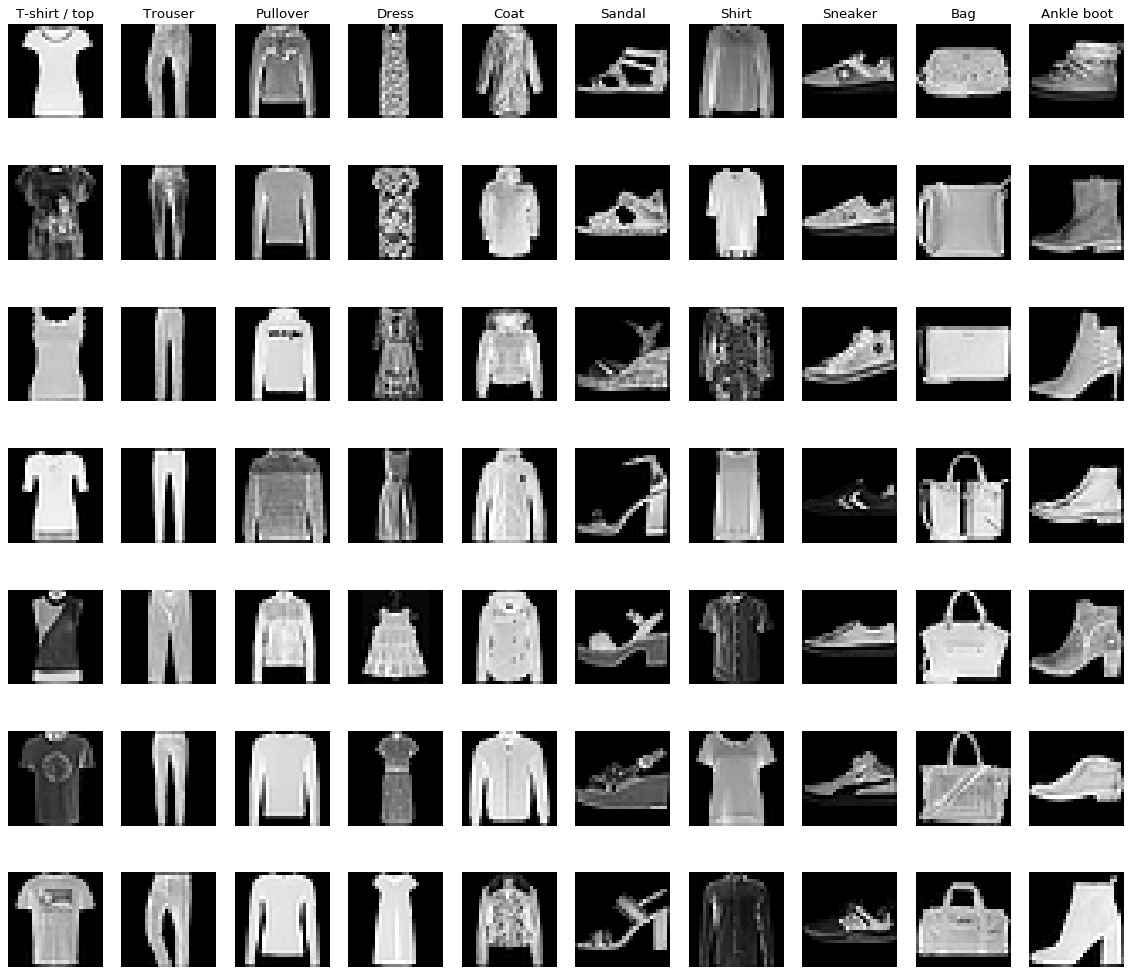

In [15]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['T-shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)
samples_per_class = 7
plt.figure(figsize=(18, 16), dpi=80)
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.array(train_dataset.labels) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img = (train_dataset.images[idx,:]).astype(np.uint8)
        img = np.resize(img, (28, 28))   # reshape to 28x28
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

---
To keep track of important parameters, we use dictionary "config". You should experiment with different values for the batch size, learning rate and number of epochs trained.

 

In [23]:
config = {
          'batch_size':128,
          'use_cuda': False,       #True=use Nvidia GPU | False use CPU
          'log_interval':20,      #How often to dislay (batch) loss during training
          'epochs': 20,           #Number of epochs
          'learningRate': 0.001
         }

With the instances of "datasetFashionMNIST" we can iterate through the data, however we would like to use pytorch's "torch.utils.data.DataLoader" class. It is convenient as it helps us with batching and shuffling of the data. It also makes it possible to use multiple CPU cores/threads to speed up data preprocessing. Your task is to instantiate two data loaders (one for each of the training and validation dataset objects), using PyTorch dataloader "torch.utils.data.DataLoader". Consider if you will use multiple workers and shuffling of data.

In [29]:
# DataLoaders

#ToDo
train_loader = torch.utils.data.DataLoader(
                dataset = train_dataset, 
                batch_size = config["batch_size"], 
                shuffle = True, 
                num_workers = 2
                )

val_loader = torch.utils.data.DataLoader(
                dataset = val_dataset, 
                batch_size = config["batch_size"], 
                shuffle = True, 
                num_workers = 2
                )

---
### Step 2: Build the model

You are now to define the network architecture. By default, the neural network is a fully connected neural network (dense neural network) with two hidden layer of size 128 and 64. We encourage you to play with the network configuration.

The input has shape [batch size, 28x28]. The 28x28 image size are being concatenated in "datasetFashionMNIST". Try to change:
- The number of layers
- The size of the hidden layers
- The activation functions


Note that the model inherits from "torch.nn.Module", which requires the two class methods "__init__" and "forward". As discussed in the lecture, the former defines the layers used by the model, while the latter defines how the layers are stacked inside the model.


In [27]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [28]:
# Creat an instance of Model
model = Model()
if config['use_cuda'] == True:
    model.to('cuda')

---
### Step 3: Define optimizer and loss function

Instantiate an optimizer, e.g. stochastic gradient descent, from the "torch.optim" module (https://pytorch.org/docs/stable/optim.html) with your model. Remember that we have defined "learning rate" inside the config-dictionary.


In [31]:
# Create an instance of "torch.optim.SGD"

#ToDo
optimizer = torch.optim.SGD(model.parameters(), lr = config["learningRate"])


---
Here we want to define the loss function (often called criterion). As we are dealing with a classification problem, you should use the softmax cross entropy loss.

Hint, have a look here: (https://pytorch.org/docs/stable/nn.html#torch-nn-functional)


In [64]:
def loss_fn(prediction, labels):
    """Returns softmax cross entropy loss."""
    print(prediction[labels].shape)
    #ToDo
    loss = torch.nn.CrossEntropyLoss()
    
    return loss(prediction, labels)

---
### Step 4: Set up the training process and train the model

You have all the building blocks needed to set up the training process. You will implement the function "run_epoch" which shall loop though a dataset and train the model.


In [65]:
def run_epoch(model, epoch, data_loader, optimizer, is_training, config):
    """
    Args:
        model        (obj): The neural network model
        epoch        (int): The current epoch
        data_loader  (obj): A pytorch data loader "torch.utils.data.DataLoader"
        optimizer    (obj): A pytorch optimizer "torch.optim"
        is_training (bool): Whether to use train (update) the model/weights or not. 
        config      (dict): Configuration parameters

    Intermediate:
        totalLoss: (float): The accumulated loss from all batches. 
                            Hint: Should be a numpy scalar and not a pytorch scalar

    Returns:
        loss_avg         (float): The average loss of the dataset
        accuracy         (float): The average accuracy of the dataset
        confusion_matrix (float): A 10x10 matrix
    """
    
    if is_training==True: 
        model.train()
    else:
        model.eval()

    total_loss        = 0 
    correct          = 0 
    confusion_matrix = np.zeros(shape=(10,10))
    labels_list      = [0,1,2,3,4,5,6,7,8,9]

    for batch_idx, data_batch in enumerate(data_loader):
        if config['use_cuda'] == True:
            images = data_batch[0].to('cuda') # send data to GPU
            labels = data_batch[1].to('cuda') # send data to GPU
        else:
            images = data_batch[0]
            labels = data_batch[1]

        if not is_training:
            with torch.no_grad():
                # ToDo: Forward
                prediction = model.forward(images)
                # ToDo: Compute loss
                # Note: It can be beneficial to detach "total_loss" from the graph, consider convert "total_loss" to numpy.
                loss        = loss_fn(prediction, labels)
                total_loss  = loss.detach()  
            
        elif is_training: 
            # ToDo: Forward
            prediction = model.forward(images)
            # ToDo: Compute loss
            # Note: It can be beneficial to detach "total_loss" from the graph, consider convert "total_loss" to numpy.
            loss        = loss_fn(prediction, labels)
            total_loss += loss.detach() 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            
            
            

        # Compute the correct classification
        predicted_label  = prediction.max(1, keepdim=True)[1][:,0]
        correct          += predicted_label.eq(labels).cpu().sum().numpy()
        confusion_matrix += metrics.confusion_matrix(labels.cpu().numpy(), predicted_label.cpu().numpy(), labels_list)

        # Print statistics
        batchSize = len(labels)
        if batch_idx % config['log_interval'] == 0:
            print(f'Epoch={epoch} | {batch_idx/len(data_loader)*100:.2f}% | loss = {loss/batchSize:.5f}')

    loss_avg         = total_loss / len(data_loader)
    accuracy         = correct / len(data_loader.dataset)
    confusion_matrix = confusion_matrix / len(data_loader.dataset)

    return loss_avg, accuracy, confusion_matrix


---
Here is where the action takes place!

In [66]:
# training the model
train_loss = np.zeros(shape=config['epochs'])
train_acc  = np.zeros(shape=config['epochs'])
val_loss   = np.zeros(shape=config['epochs'])
val_acc    = np.zeros(shape=config['epochs'])
val_confusion_matrix   = np.zeros(shape=(10,10,config['epochs']))
train_confusion_matrix = np.zeros(shape=(10,10,config['epochs']))

for epoch in range(config['epochs']):
    train_loss[epoch], train_acc[epoch], train_confusion_matrix[:,:,epoch] = \
                               run_epoch(model, epoch, train_loader, optimizer, is_training=True, config=config)

    val_loss[epoch], val_acc[epoch], val_confusion_matrix[:,:,epoch]     = \
                               run_epoch(model, epoch, val_loader, optimizer, is_training=False, config=config)

torch.Size([128, 10])
Epoch=0 | 0.00% | loss = 7.05656
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=0 | 4.26% | loss = 2.16597
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=0 | 8.53% | loss = 0.85069

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=0 | 81.02% | loss = 0.01040
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=0 | 85.29% | loss = 0.00991
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=1 | 38.38% | loss = 0.01023
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=1 | 42.64% | loss = 0.01121
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=1 | 75.95% | loss = 0.00917
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([16, 10])
torch.Size([128, 10])
Epoch=2 | 0.00% | loss = 0.00865
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=2 | 72.49% | loss = 0.00768
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=2 | 76.76% | loss = 0.00758
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=3 | 29.85% | loss = 0.00724
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=3 | 34.12% | loss = 0.00648
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=3 | 50.63% | loss = 0.00676
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=3 | 75.95% | loss = 0.00717
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=4 | 63.97% | loss = 0.00596
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=4 | 68.23% | loss = 0.00667
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
Epoch=5 | 21.32% | loss = 0.00608
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=5 | 25.59% | loss = 0.00550
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=5 | 29.85% | loss = 0.00

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=5 | 98.08% | loss = 0.00536
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([96, 10])
torch.Size([128, 10])
Epoch=5 | 0.00% | loss = 0.00703
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=6 | 55.44% | loss = 0.00553
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=6 | 59.70% | loss = 0.00609
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=7 | 12.79% | loss = 0.00601
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=7 | 17.06% | loss = 0.00544
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=7 | 89.55% | loss = 0.00530
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=7 | 93.82% | loss = 0.00610
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=8 | 46.91% | loss = 0.00579
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=8 | 51.17% | loss = 0.00561
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=9 | 4.26% | loss = 0.00558
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=9 | 8.53% | loss = 0.00511
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size

torch.Size([128, 10])
Epoch=9 | 81.02% | loss = 0.00535
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=9 | 85.29% | loss = 0.00598
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=9 | 89.55% | loss = 0.00

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=10 | 42.64% | loss = 0.00399
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=10 | 46.91% | loss = 0.00482
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([16, 10])
torch.Size([128, 10])
Epoch=11 | 0.00% | loss = 0.00467
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=11 | 4.26% | loss = 0.00549
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Siz

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=11 | 76.76% | loss = 0.00459
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=11 | 81.02% | loss = 0.00597
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
Epoch=12 | 34.12% | loss = 0.00498
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=12 | 38.38% | loss = 0.00405
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=12 | 50.63% | loss = 0.00569
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=12 | 75.95% | loss = 0.00462
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([16, 10])
torch.S

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=13 | 68.23% | loss = 0.00517
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=13 | 72.49% | loss = 0.00409
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=14 | 25.59% | loss = 0.00504
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=14 | 29.85% | loss = 0.00446
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
Epoch=14 | 0.00% | loss = 0.00469
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=14 | 25.32% | loss = 0.00447
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=14 | 50.63% | loss = 0.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=15 | 59.70% | loss = 0.00409
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=15 | 63.97% | loss = 0.00415
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=16 | 21.32% | loss = 0.00312
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=16 | 25.59% | loss = 0.00467
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=16 | 98.08% | loss = 0.00455
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([96, 10])
torch.Size([128, 10])
Epoch=16 | 0.00% | loss = 0.00480
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Si

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=17 | 55.44% | loss = 0.00341
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=17 | 59.70% | loss = 0.00362
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=18 | 17.06% | loss = 0.00375
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=18 | 21.32% | loss = 0.00378
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=18 | 93.82% | loss = 0.00367
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=18 | 98.08% | loss = 0.00354
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=19 | 51.17% | loss = 0.00445
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
Epoch=19 | 55.44% | loss = 0.00386
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.Size([128, 10])
torch.

---
### Step 5. Plot train and validation loss
Plot the loss and the accuracy as a function of epochs to monitor the training.


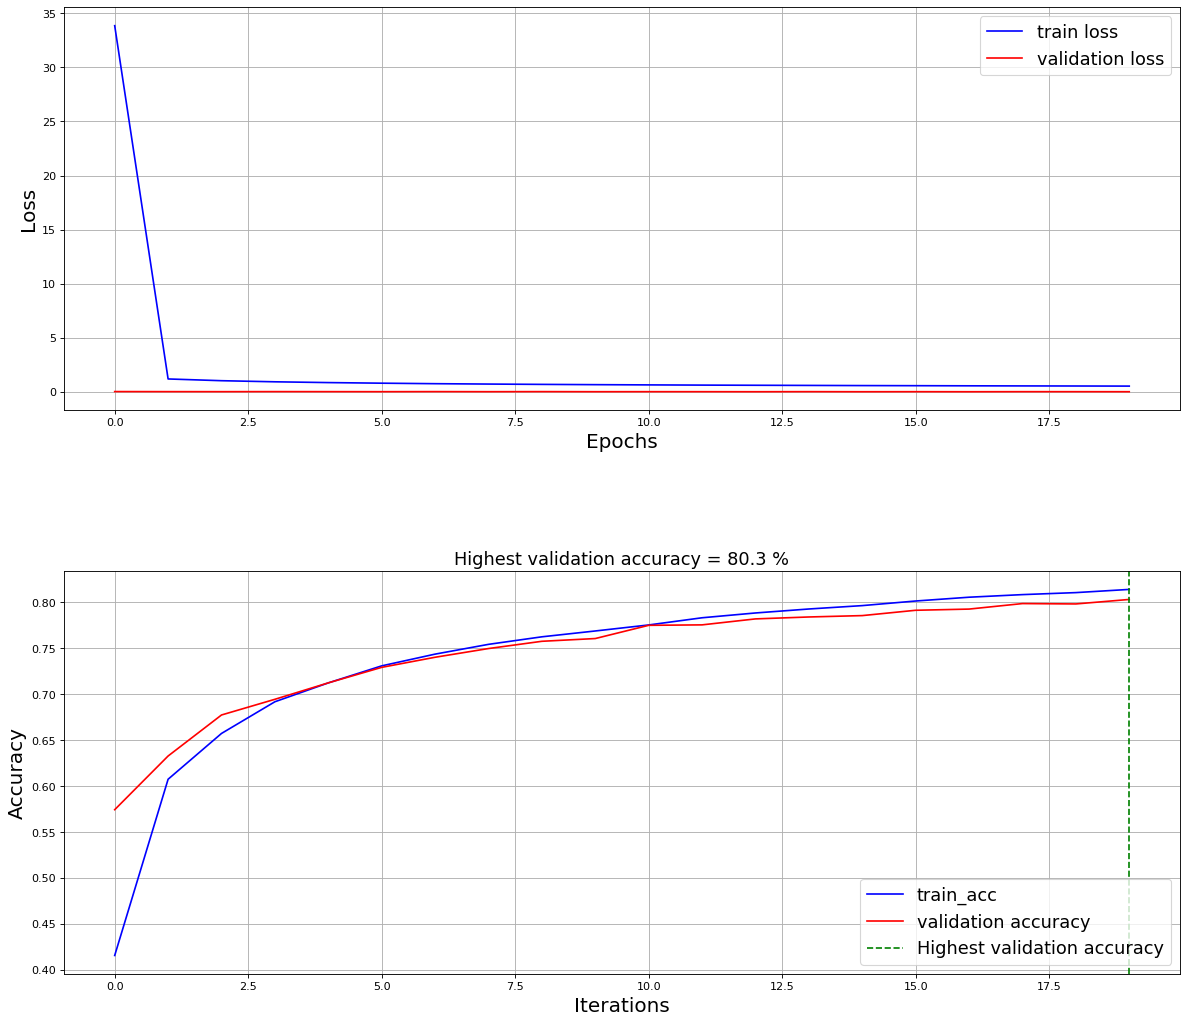

In [67]:
# Plot the training accuracy and the training loss
#plt.figure()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(2, 1, 1)
# plt.subplots_adjust(hspace=2)
ax.plot(train_loss, 'b', label='train loss')
ax.plot(val_loss, 'r', label='validation loss')
ax.grid()
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
ax.legend(loc='upper right', fontsize=16)

ax = plt.subplot(2, 1, 2)
plt.subplots_adjust(hspace=0.4)
ax.plot(train_acc, 'b', label='train_acc')
ax.plot(val_acc, 'r', label='validation accuracy')
ax.grid()
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Iterations', fontsize=18)
val_acc_max = np.max(val_acc)
val_acc_max_ind = np.argmax(val_acc)
plt.axvline(x=val_acc_max_ind, color='g', linestyle='--', label='Highest validation accuracy')
plt.title('Highest validation accuracy = %0.1f %%' % (val_acc_max*100), fontsize=16)
ax.legend(loc='lower right', fontsize=16)
plt.ion()

---
Let us study the accuracy per class on the validation dataset. We use the result from the epoch with highest validation accuracy.


In [ ]:
ind = np.argmax(val_acc)
class_accuracy = val_confusion_matrix[:,:,ind]
for ii in range(len(classes)):
    acc = val_confusion_matrix[ii,ii,ind] / np.sum(val_confusion_matrix[ii,:,ind])
    print(f'Accuracy of {str(classes[ii]).ljust(15)}: {acc*100:.01f}%')

---
In order to see how the network learns to distinguish the different classes as the training progresses we can plot the confusion matrices as heatmaps. 

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epoch_step                  = 2    
set_colorbar_max_percentage = 10 
    
# Plot confusion matrices
ticks = np.linspace(0,9,10)
gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.0, right=0.9, wspace=0.5, hspace=0.2)
for i in range(0, config['epochs'], epoch_step):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16), gridspec_kw=gridspec_kwargs)
    im = ax1.imshow(val_confusion_matrix[:, :, i]*100)
    ax1.set_title(f'Validation: Epoch #{i}', fontsize=18)
    ax1.set_xticks(ticks=ticks)
    ax1.set_yticks(ticks=ticks)
    ax1.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_ylabel('Prediction', fontsize=16)
    ax1.set_xlabel('Groundtruth', fontsize=16)
    divider = make_axes_locatable(ax1)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')
    
    im = ax2.imshow(train_confusion_matrix[:, :, i]*100)
    ax2.set_title(f'Train: Epoch #{i}', fontsize=18)
    ax2.set_xticks(ticks=ticks)
    ax2.set_yticks(ticks=ticks)
    ax2.set_yticklabels(classes)
    im.set_clim(0.0, set_colorbar_max_percentage)
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_ylabel('Prediction', fontsize=16)
    ax2.set_xlabel('Ground truth', fontsize=16)
    divider = make_axes_locatable(ax2)
    cax     = divider.append_axes('right', size='5%', pad=0.15)
    f.colorbar(im, cax=cax, orientation='vertical')    